In [3]:
from sklearn.manifold import TSNE
import torch
import os
import pickle

import numpy as np
import torch.nn as nn
import torchvision.models as models
from tqdm.auto import tqdm

from policy import config
from policy.dataset.ms2dataset import get_MS_loaders
from policy.checkpoints import CheckpointIO

model_dir = "/home/mrl/Documents/Projects/tskill/out/PegInsertion/VAE/034"
cfg_path = os.path.join(model_dir, "config.yaml")
cfg = config.load_config(cfg_path, None)

# Dataset
cfg["data"]["pad"] = False
cfg["data"]["augment"] = False
cfg["data"]["full_seq"] = False
cfg["data"]["max_count"] = 0
cfg["data"]["val_split"] = 0
cfg["data"]["dataset"] = "/home/mrl/Documents/Projects/tskill/data/demos/v0/rigid_body/PegInsertionSide-v0/trajectory.rgbd.pd_joint_delta_pos_256.h5"

# Load only the full episode version of the dataset
train_dataset, val_dataset = get_MS_loaders(cfg, return_datasets=True, 
                                            save_override=True,
                                            fullseq_override=True,
                                            preshuffle=False)
print(len(train_dataset), len(val_dataset))
# Model
model = config.get_model(cfg, device="cpu")
checkpoint_io = CheckpointIO(model_dir, model=model)
load_dict = checkpoint_io.load("model_best.pt")
stt_encoder = model.stt_encoder
model.eval()

Found existing data info file
Loading indices from file: out/PegInsertion/VAE/034/data_info.pickle
Overriding full seq config!
Loading action and state scaling from file
Adding batch dimension to returned data!
45 5
freezing state encoder network!
/home/mrl/Documents/Projects/tskill/out/PegInsertion/VAE/034/model_best.pt
=> Loading checkpoint from local file...


/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but

load state dict: <All keys matched successfully>


TSkillCVAE(
  (decoder): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
       

In [4]:
mus = torch.zeros((0,model.z_dim))

for i in tqdm(range(len(train_dataset))):
        data = train_dataset[i]
        
        with torch.no_grad():
            out = model(data, use_precalc=True)
        
        mus = torch.vstack((mus, out["mu"].squeeze()))

  0%|          | 0/45 [00:00<?, ?it/s]

In [5]:
tsne = TSNE(3, perplexity=10, early_exaggeration=20)
tsne_results = tsne.fit_transform(mus)

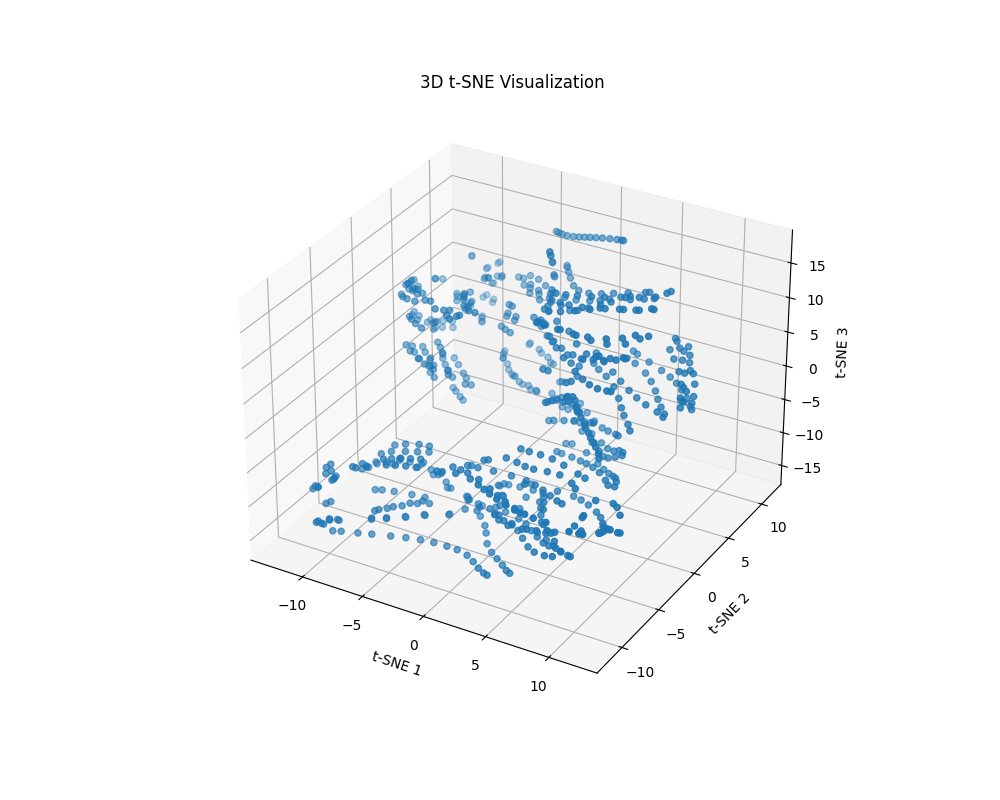

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

# Plot the 3D results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2])
ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.show()

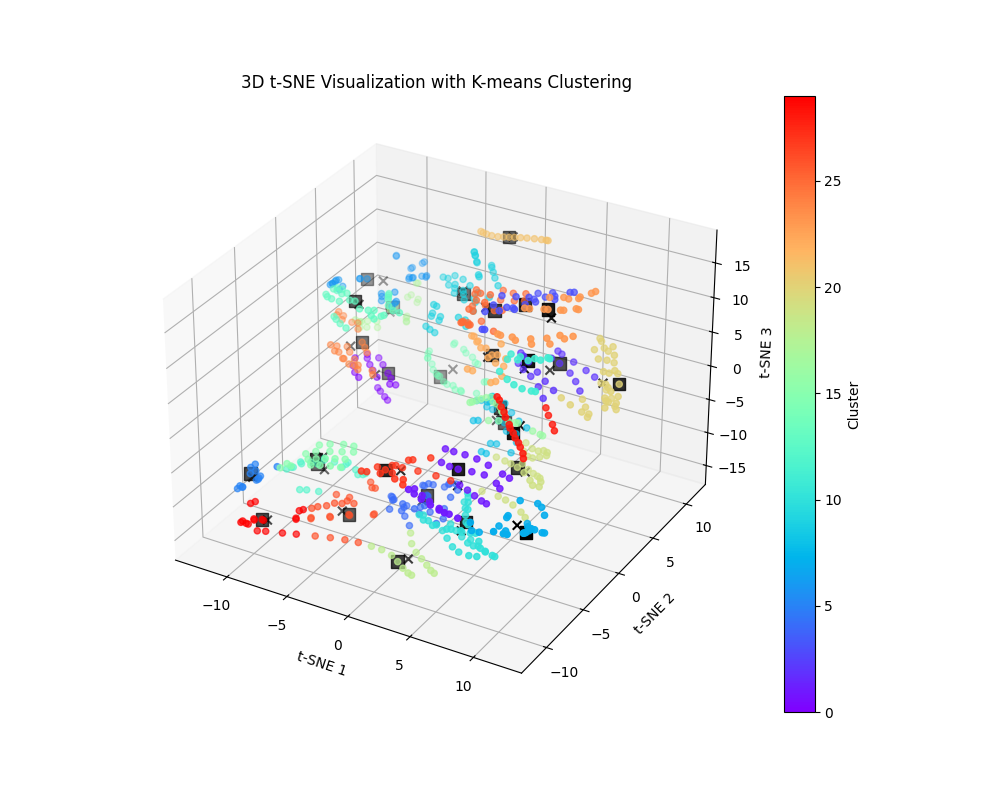

In [7]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# Perform k-means clustering on t-SNE results
n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=11)
cluster_labels = kmeans.fit_predict(tsne_results)
cluster_centroids = kmeans.cluster_centers_
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(tsne_results)

# Find the indices of the nearest neighbors to the centroids
_, centroid_indices = nn.kneighbors(cluster_centroids)

# Get the corresponding points in the original space
tsne_centroids = tsne_results[centroid_indices.flatten()]
original_centroids = mus[centroid_indices.flatten()]

# Plot the clustered results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], c=cluster_labels, cmap='rainbow')
scatter2 = ax.scatter(cluster_centroids[:,0],cluster_centroids[:,1],cluster_centroids[:,2],c='k',s=40,marker='x')
scatter2 = ax.scatter(tsne_centroids[:,0],tsne_centroids[:,1],tsne_centroids[:,2],c='k',s=80,marker='s')

ax.set_title('3D t-SNE Visualization with K-means Clustering')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.colorbar(scatter, label='Cluster')
plt.show()

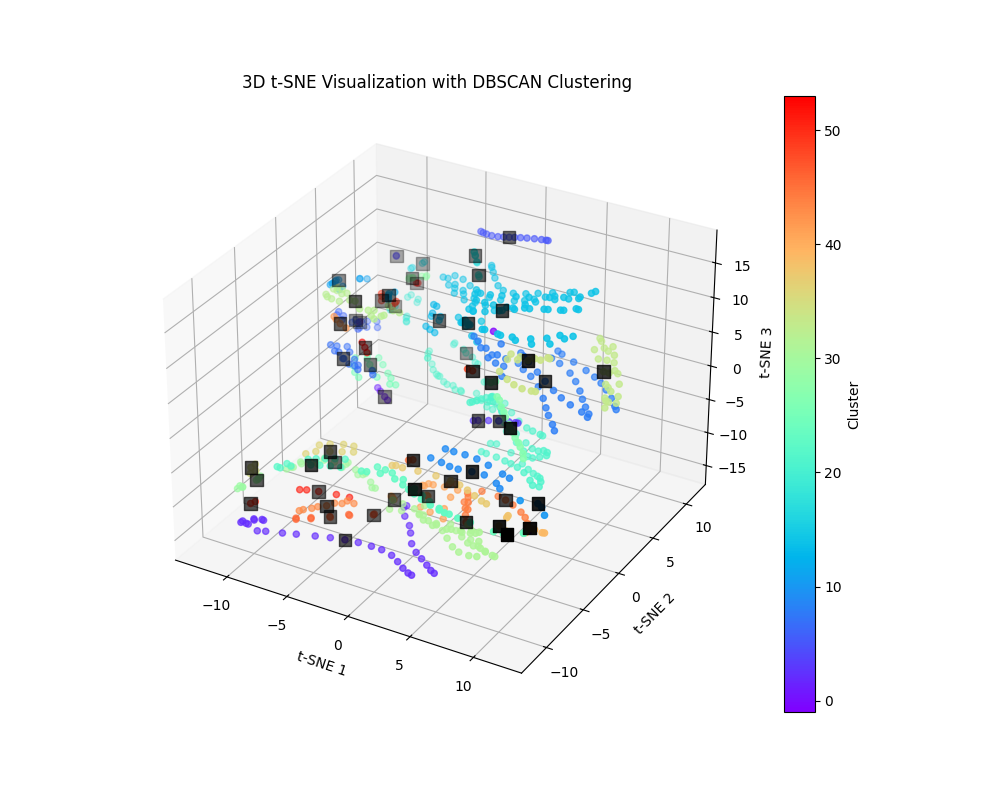

In [8]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

clustering_method = DBSCAN(eps=1.5, min_samples=2)  # Adjust these parameters as needed
cluster_labels = clustering_method.fit_predict(tsne_results)

# Get unique cluster labels
unique_labels = np.unique(cluster_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Exclude noise if present

# Find cluster centers in t-SNE space
tsne_centers = np.array([tsne_results[cluster_labels == label].mean(axis=0) 
                         for label in unique_labels if label != -1])

# Find the nearest neighbors in t-SNE space
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(tsne_results)

# Find the indices of the nearest neighbors to the cluster centers
_, center_indices = nn.kneighbors(tsne_centers)

# Get the corresponding points in the original space
tsne_centroids = tsne_results[center_indices.flatten()]
original_representatives = mus[center_indices.flatten()]

# Plot the clustered results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], c=cluster_labels, cmap='rainbow')
scatter2 = ax.scatter(tsne_centroids[:,0],tsne_centroids[:,1],tsne_centroids[:,2],c='k',s=80,marker='s')

ax.set_title('3D t-SNE Visualization with DBSCAN Clustering')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [11]:
# THIS CODE VISUALIZES THE CENTROIDS OF THE CLUSTERED T-SNE RESULTS

import gymnasium as gym
import h5py
import numpy as np
import torch
import time

import sapien.core as sapien
import torch
from tqdm.auto import tqdm

from mani_skill2.agents.controllers import *
from mani_skill2.envs.sapien_env import BaseEnv
from mani_skill2.utils.io_utils import load_json
from mani_skill2.utils.wrappers import RecordEpisode

# pbar = tqdm(position=0, leave=None, unit="step", dynamic_ncols=True)
pbar = None

# Load HDF5 containing trajectories
traj_path = cfg["data"]["dataset"]
ori_h5_file = h5py.File(traj_path, "r")

# Load associated json
json_path = traj_path.replace(".h5", ".json")
json_data = load_json(json_path)

env_info = json_data["env_info"]
env_id = env_info["env_id"]
ori_env_kwargs = env_info["env_kwargs"]
max_episode_steps = env_info["max_episode_steps"]

ori_env = gym.make(env_id, **ori_env_kwargs)

# Create a main env for replay
env_kwargs = ori_env_kwargs.copy()
env_kwargs[
    "render_mode"
] = "rgb_array"  # note this only affects the videos saved as RecordEpisode wrapper calls env.render
env = gym.make(env_id, **env_kwargs)

# Prepare for recording
output_dir = 'out/'
ori_traj_name = os.path.splitext(os.path.basename(traj_path))[0]
suffix = "{}.{}".format(env.obs_mode, env.control_mode)
new_traj_name = ori_traj_name + "." + suffix

env = RecordEpisode(
    env,
    output_dir,
    save_on_reset=False,
    save_trajectory=False,
    trajectory_name=new_traj_name,
    save_video=False,
)

if env.save_trajectory:
    output_h5_path = env._h5_file.filename
    assert not os.path.samefile(output_h5_path, traj_path)
else:
    output_h5_path = None

episodes = json_data["episodes"]
n_ep = len(episodes)
inds = np.arange(n_ep)

idxs = train_dataset.owned_indices
src_pad_mask = torch.zeros(1,1)
tgt_pad_mask = torch.zeros(1, model.max_skill_len)

# Replay
for i in tqdm(range(len(original_representatives))):
    ind = idxs[0]
    ep = episodes[ind]
    episode_id = ep["episode_id"]
    traj_id = f"traj_{episode_id}"

    data = train_dataset[0]
    latent = mus[i:i+1,:].unsqueeze(0)
    with torch.no_grad():
        model.conditional_decode = False
        a_hat = model.skill_decode(latent, None, None, 
                                 src_pad_mask, tgt_pad_mask)
        a_hat = a_hat.permute(1,0,2)

    if pbar is not None:
        pbar.set_description(f"Replaying {traj_id}")

    if traj_id not in ori_h5_file:
        tqdm.write(f"{traj_id} does not exist in {traj_path}")
        continue

    reset_kwargs = ep["reset_kwargs"].copy()
    if "seed" in reset_kwargs:
        assert reset_kwargs["seed"] == ep["episode_seed"]
    else:
        reset_kwargs["seed"] = ep["episode_seed"]
    seed = reset_kwargs.pop("seed")

    env.reset(seed=seed, options=reset_kwargs)
    if ori_env is not None:
        ori_env.reset(seed=seed, options=reset_kwargs)

    env.render_human()
    time.sleep(1)

    # Run model to reconstruct actions
    a_hat = a_hat.detach().cpu().squeeze()
    a_hat = train_dataset.action_scaling(a_hat, "inverse").numpy()
    pred_actions = []
    for i in range(a_hat.shape[0]):
        pred_actions.append(a_hat[i,:])

    info = {}
    ori_env_state = ori_h5_file[traj_id]["env_states"][1]
    env.set_state(ori_env_state)

    # Without conversion between control modes
    n = len(pred_actions)
    if pbar is not None:
        pbar.reset(total=n)

    for t, a in enumerate(pred_actions):
        if pbar is not None:
            pbar.update()
        _, _, _, _, info = env.step(a)

        env.render_human()
    
env.close()

[2024-07-23 14:13:50.219] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
[2024-07-23 14:13:50.285] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


  0%|          | 0/54 [00:00<?, ?it/s]